1. Installing/importing lyricsgenius
2. Getting the API key and access so that we can access lyrics genius stuff
3. Solving timeout problem & importing our rapper list from csv, saving it as rappers_list
4. Checking if artists from our list exist in Genius 
5. Using the get_info and get_lyrics functions in a function with a for loop on our rappers list to construct data frame where every row is a song, this will only have top 10 songs of every artist and this process is kinda difficult to make automatic cause not all artists on our list have more than 10 songs and if they don't we get an error that list index is out of range. I might just construct this dataframe by hand cause i just want it to be done so that we can move on hahah. 


### 1. Installing/importing lyricsgenius

In [ ]:
# !pip install lyricsgenius

### 2. Getting the API key and access so that we can access lyrics genius stuff

In [2]:
import lyricsgenius
my_token  = "BbI104BwqEgGemxyZCxkV4EAgdjmJG7JV6snrcSMfG43JN4DkRe4RI_yRToc8_kw"
my_token2 = "4W3f61hvZSmrhnGFonZIsKqBgaCFkKJLJpWUCwO9Ab4XmDJGvb82FI-1agcYP_nd"

if my_token2 is not None:
    genius = lyricsgenius.Genius(my_token2)

### 3. Solving timeout problem & importing our rapper list from csv, saving it as rappers_list

In [3]:
import pandas as pd
import numpy as np
rappers_list = pd.read_csv("rapperlist.csv")
rappers_list = rappers_list["name"]
# Sorting names alphabetically 
rappers_list = sorted(rappers_list)
# Removing duplicates
rappers_list = list(dict.fromkeys(rappers_list))
print(rappers_list)

['Bedoes', 'Belmondawg', 'Białas', 'Biały', 'Bonson', 'Bonus RPK', 'Borixon', 'Buka', 'Eldo', 'Fisz Emade', 'Gutek', 'Hemp Gru', 'Holak', 'JWP', 'Jacuś', 'Jan-rapowanie', 'Kabe', 'Kafar Dixon 37', 'Kali', 'Kaliber 44', 'Kasta', 'Kuba Knap', 'Kubańczyk', 'Kuki', 'Kukon', 'KęKę', 'Lanek', 'Leh', 'Liroy', 'Malik Montana', 'Mata', 'Miuosh', 'Molesta Ewenement', 'Młody Dzban', 'Otsochodzi', 'Paktofonika', 'Paluch', 'Peja', 'Pelson', 'Pezet', 'Pikers', 'PlanBe', 'Problem', 'Płomień 81', 'Quebonafide', 'Rasmentalism', 'SYNY', 'Shellerini', 'Sokół', 'Solar', 'Stare Miasto', 'Stereofonia', 'Szad', 'Szpaku', 'Taco Hemingway', 'Tede', 'Tymek', 'UNDADASEA', 'Vienio', 'Vixen', 'Wac Toja', 'Warszafski Deszcz', 'Wzgórze Ya-Pa 3', 'Włodi', 'Young Leosia', 'Young Multi', 'Z.B.U.K.U.', 'Zdechły Osa', 'Ziomcy', 'asthma', 'donGURALesko', 'schafter', 'ten typ mes', 'ĆPAJ STAJL', 'Łona i Webber', 'Żabson']


In [5]:
# import requests

# base_url = 'https://api.genius.com/search?q='

# for query in rappers_list:
#     # Build the URL for the current search query
#     url = base_url + query.replace(' ', '%800')
    
#     # Set the headers for the API request
#     headers = {'Authorization': f'Bearer {my_token}'}
    
#     # Make the API request
#     response = requests.get(url, headers=headers)

### 4. Checking if artists from our list exist in Genius, and whether they have at least one song there

In [4]:
def name_correct(my_list):
    not_found=[]
    for name in my_list:
        artist = genius.search_artist(name, max_songs=1, sort='title')
        if artist is None:
            not_found.append(name)
    for name in not_found:
        print(f"Artist not found: {name}.")

In [ ]:
name_correct(rappers_list) 
# Artist not found: Jędrek Realista.
# Artist not found: tabasko/ostr.

I removed those from our list and then encountered problems still with a couple of artists. 

Significant name changes still causing problems after/during compling dataset:
* Avi, B.R.O. --> removed from list
* JWP to Młody Dron???? --> finds zero songs
* Leh to A-Reece???? - @MichaLeszner --> problematic cause it throws out some other artist whenever i search Leh but it is possible to find his songs by their names
* Kasta to КасTа (Kasta) --> gives a russian band instead of K.A.S.T.A.
* Kali --> gives an american artist instead of a Polish rapper
 

In [ ]:
# rappers_list.remove("Jędrek Realista")
# rappers_list.remove("tabasko/ostr")
# print(rappers_list)

# 6.1. Best function we have - it does everything!!!!!

I made two version of this function - one that also gets years when song was released and one that doesn't - cause for some artists its not possible for some reason. 

* Get_everything + make_csv &rarr; gives you a dataframe with a year column that's filled with the release year of the song
* Get_lyrics + make_dataset &rarr; gives you a dataframe with a year column that is 0

In [57]:
import re 
from nltk.tokenize import RegexpTokenizer
import pandas as pd

tokenizer = RegexpTokenizer(r'\w+')
pattern = r'(Intro|\d+\s+Contributors[\w+\s]*\w+|1 Contributor|You might also likeEmbed|Refren|Hook|Lyrics|\d+Embed|Zwrotka(?: \d+)?)'

def get_everything(artist_name):
    result = genius.search_artist(artist_name, max_songs = 30, sort = 'popularity') 
    list_of_dictionaries = list()
    for song in result.songs:
        cleaned_lyrics = re.sub(pattern, "", song.lyrics)
        tokenized_lyrics = tokenizer.tokenize(cleaned_lyrics)
        
        if genius.search_song(title = song.title) is not None:
            
            list_of_dictionaries.append({
                "artist name" : artist_name,
                "title": song.title,
                "year" : genius.search_song(title = song.title).__dict__['_body']['release_date_components']['year'], 
                "clean lyrics": cleaned_lyrics, 
                "tokens" : tokenized_lyrics})
        else: 
            list_of_dictionaries.append({
                "artist name" : artist_name,
                "title": song.title,
                "year" : 0, 
                "clean lyrics": cleaned_lyrics, 
                "tokens" : tokenized_lyrics})
        
    return pd.DataFrame.from_dict(list_of_dictionaries)

def make_csv(artist_list):
    result = pd.DataFrame()
    for artist in artist_list:
        artist_df = get_everything(artist)
        result = pd.concat([result, artist_df])
        result.to_csv(f"{artist}.csv", index=False)
    return result
        

In [249]:
print(rappers_list)

['Bedoes', 'Belmondawg', 'Białas', 'Biały', 'Bonson', 'Bonus RPK', 'Borixon', 'Buka', 'Eldo', 'Fisz Emade', 'Gutek', 'Hemp Gru', 'Holak', 'JWP', 'Jacuś', 'Jan-rapowanie', 'Kabe', 'Kafar Dixon 37', 'Kali', 'Kaliber 44', 'Kasta', 'Kuba Knap', 'Kubańczyk', 'Kuki', 'Kukon', 'KęKę', 'Lanek', 'Leh', 'Liroy', 'Malik Montana', 'Mata', 'Miuosh', 'Molesta Ewenement', 'Młody Dzban', 'Otsochodzi', 'Paktofonika', 'Paluch', 'Peja', 'Pelson', 'Pezet', 'Pikers', 'PlanBe', 'Problem', 'Płomień 81', 'Quebonafide', 'Rasmentalism', 'SYNY', 'Shellerini', 'Sokół', 'Solar', 'Stare Miasto', 'Stereofonia', 'Szad', 'Szpaku', 'Taco Hemingway', 'Tede', 'Tymek', 'UNDADASEA', 'Vienio', 'Vixen', 'Wac Toja', 'Warszafski Deszcz', 'Wzgórze Ya-Pa 3', 'Włodi', 'Young Leosia', 'Young Multi', 'Z.B.U.K.U.', 'Zdechły Osa', 'Ziomcy', 'asthma', 'donGURALesko', 'schafter', 'ten typ mes', 'ĆPAJ STAJL', 'Łona i Webber', 'Żabson']


### 6.2. Second Best function

In [291]:
import re 
from nltk.tokenize import RegexpTokenizer
import pandas as pd

tokenizer = RegexpTokenizer(r'\w+')
pattern = r'(Intro|\d+\s+Contributors[\w+\s]*\w+|1 Contributor|You might also likeEmbed|Refren|Hook|Lyrics|\d+Embed|Zwrotka(?: \d+)?)'

def get_lyrics(artist_name):
    result = genius.search_artist(artist_name, max_songs = 30, sort = 'popularity') 
    list_of_dictionaries = list()
    for song in result.songs:
        cleaned_lyrics = re.sub(pattern, "", song.lyrics)
        tokenized_lyrics = tokenizer.tokenize(cleaned_lyrics)
        list_of_dictionaries.append({
            "artist name" : artist_name,
            "title": song.title,
            "year" : 0,
            "clean lyrics": cleaned_lyrics, 
            "tokens" : tokenized_lyrics})
         
    return pd.DataFrame.from_dict(list_of_dictionaries)

def make_dataset(artist_list):
    result = pd.DataFrame()
    for artist in artist_list:
        artist_df = get_lyrics(artist)
        result = pd.concat([result, artist_df])
        result.to_csv(f"{artist}.csv", index=False, encoding = "UTF-8")
        
    return result
#         

In [216]:
combo = pd.concat([bedoes, bialas])
combo

artist name                         title  year  \
0       Bedoes                        Gustaw  2017   
1       Bedoes      Kwiat Polskiej Młodzieży  2018   
2       Bedoes              #hot16Challenge2  2020   
3       Bedoes                  NaNaNa REMIX  2015   
4       Bedoes                       Jumpman  2015   
5       Bedoes                          Ibra  2013   
6       Bedoes                         A ty?  2016   
7       Bedoes         Wpłatomat (TomB diss)  2018   
8       Bedoes           AŚMZ (Filipek diss)  2017   
9       Bedoes      Puszki, kartony, butelki  2015   
10      Bedoes        Pinokio (Filipek diss)  2017   
11      Bedoes                   Co słychać?  2015   
12      Bedoes                          BRRR  2015   
13      Bedoes    Rocket Jump (Filipek diss)  2017   
14      Bedoes                  Ruskie Fajki  2015   
15      Bedoes  00:45 (Rest Dix37 odpowiedź)  2018   
16      Bedoes                     2115 FLOW  2015   
17      Bedoes                          Mula  2017   
18      Bedoes                    KOCHAM CIĘ  2018   
19      Bedoes                Nie myśl o tym  2018   
20      Bedoes               #hot16challenge  2014   
21      Bedoes                 Beddy Soprano  2016   
22      Bedoes                  MORGAN JONES  2016   
23      Bedoes                          FANI  2018   
24      Bedoes               Robinson Cruzoe  2019   
0       Białas    Mali ludzie, wielkie nieba  2016   
1       Białas     Street Credit (Freestyle)  2015   
2       Białas              Tracimy kontrolę  2016   
3       Białas               Blakablakablaka  2016   
4       Białas                         Drift  2016   
5       Białas         Patrzcie idzie frajer  2016   
6       Białas                           PDW  2020   
7       Białas             W Imię Ojca Trapu  2020   
8       Białas                       Art-Hop  2020   
9       Białas             Zło Jest Wszędzie  2020   
10      Białas       Jedna wiara jeden skład  2016   
11      Białas                Witam Cię 2k16  2016   
12      Białas                          Sępy  2020   
13      Białas                     Jeden żyć  2016   
14      Białas              Złamane Skrzydło  2015   
15      Białas        Nowy Biggie (TPS diss)  2018   
16      Białas                        Chamer  2016   
17      Białas             Smutne Miasteczko  2020   
18      Białas                   Swoosh Gang  2020   
19      Białas                     I poszedł  2016   
20      Białas               To jest hip-hop  2015   
21      Białas                        Piękna  2020   
22      Białas     Nie śpię bo trzymam gardę  2016   
23      Białas                       Morfina  2019   
24      Białas                  Czasem Czuję  2014   

                                         clean lyrics  \
0   []\n(Jaok: Yyy, a jak oceniasz tę nową falę, k...   
1   []\nPora już wyłożyć prawdę na stół\nZ mamą dz...   
2   #hot16Challenge2 []\nCześć, z tej strony Borys...   
3   [: Bedoes]\nNigdy nie pozwolę być rodzinie gło...   
4   []\nEj, to jest Bedoes, to jest remix Jumpman,...   
5   []\nNie chcę wiedzieć po ile masz gram, nie ch...   
6   ? [Wstęp]\nJestem nieśmiertelny, nie dasz rady...   
7    (TomB diss) []\nGustaw szarpie smycz, pędzą p...   
8    (Filipek diss) [Producent: Kubi Producent]\n\...   
9   , kartony, butelki []\nPuszki, kartony, butelk...   
10   (Filipek diss) []\nBorys a.k.a. Bedoes 2115 a...   
11  ? [Verse 1]\nW twoich oczach widze siebie\nI d...   
12  []\nOna się mnie pyta ile jeszcze może zostać,...   
13   (Filipek diss) []\nA jak wszyscy wiemy, żeby ...   
14  []\nMoje życie nigdy nie było pewne\nNie żyję ...   
15  :45 (Rest Dix37 odpowiedź) []\nTo my, ukryty w...   
16  [Verse 1]\n\nNie poznaje już sam siebie, miłoś...   
17  [: Bedoes]\nFamas, uzi, kałasz robi "prr!"\nPó...   
18  []\nByłaś dla mnie wszystkim...\nNaprawdę...\n...   
19  []\nDon't think about it too much, too much, t...   
20  #hot16challenge To jest hot 16 challenge, daj .

### 7. Combining the artist specific .csvs into one big one

In [42]:
# rappers_list.remove('PlanBe')
# rappers_list.append('Plan Be')
rappers_list

NameError: name 'rappers_list' is not defined

In [8]:
# import pandas as pd
# dataset = pd.DataFrame()

# for artist in rappers_list:
#     single_df = pd.read_csv(f"{artist}.csv")
#     dataset = pd.concat([dataset, single_df])
    
    
# dataset.to_csv("Rappers_collected_10_May.csv", index=False, encoding = "UTF-8")
# dataset

* Reading the dataset

In [5]:
pd.read_csv("Rappers_collected_10_May_UTF8.csv")

artist name                     title  year  \
0         Bedoes                    Gustaw  2017   
1         Bedoes  Kwiat Polskiej Młodzieży  2018   
2         Bedoes          #hot16Challenge2  2020   
3         Bedoes              NaNaNa REMIX  2015   
4         Bedoes                   Jumpman  2015   
...          ...                       ...   ...   
1977     Plan Be                Potrzebuję  2019   
1978     Plan Be                     Wiele  2017   
1979     Plan Be                  Pamiętam  2017   
1980     Plan Be             Złoty Chłopak  2019   
1981     Plan Be      Kryzysowa narzeczona  1983   

                                           clean lyrics  \
0     []\n(Jaok: Yyy, a jak oceniasz tę nową falę, k...   
1     []\nPora już wyłożyć prawdę na stół\nZ mamą dz...   
2     #hot16Challenge2 []\nCześć, z tej strony Borys...   
3     [: Bedoes]\nNigdy nie pozwolę być rodzinie gło...   
4     []\nEj, to jest Bedoes, to jest remix Jumpman,...   
...                                                 ...   
1977  [: PlanBe]\nPotrzebuję czegoś więcej wciąż\nŻy...   
1978  []\nWidzę wiele, wiele kłamstw\nWidzę wiele, w...   
1979  []\nNie zapomniałem kto mi mówił, że dla takic...   
1980  []\nYeah, yeah\nPlanek mówią na mnie\nYeah, ye...   
1981  [ x2]\nJak kryzysowa narzeczona\nPrzychodzisz ...   

                                                 tokens  
0     ['Jaok', 'Yyy', 'a', 'jak', 'oceniasz', 'tę', ...  
1     ['Pora', 'już', 'wyłożyć', 'prawdę', 'na', 'st...  
2     ['hot16Challenge2', 'Cześć', 'z', 'tej', 'stro...  
3     ['Bedoes', 'Nigdy', 'nie', 'pozwolę', 'być', '...  
4     ['Ej', 'to', 'jest', 'Bedoes', 'to', 'jest', '...  
...                                                 ...  
1977  ['PlanBe', 'Potrzebuję', 'czegoś', 'więcej', '...  
1978  ['Widzę', 'wiele', 'wiele', 'kłamstw', 'Widzę'...  
1979  ['Nie', 'zapomniałem', 'kto', 'mi', 'mówił', '...  
1980  ['Yeah', 'yeah', 'Planek', 'mówią', 'na', 'mni...  
1981  ['x2', 'Jak', 'kryzysowa', 'narzeczona', 'Przy...  

[1982 rows x 5 columns]

In [6]:
import pandas as pd

In [6]:
loaded_dataset = pd.read_csv("Rappers_collected_10_May_UTF8.csv")

In [7]:
loaded_dataset

artist name                     title  year  \
0         Bedoes                    Gustaw  2017   
1         Bedoes  Kwiat Polskiej Młodzieży  2018   
2         Bedoes          #hot16Challenge2  2020   
3         Bedoes              NaNaNa REMIX  2015   
4         Bedoes                   Jumpman  2015   
...          ...                       ...   ...   
1977     Plan Be                Potrzebuję  2019   
1978     Plan Be                     Wiele  2017   
1979     Plan Be                  Pamiętam  2017   
1980     Plan Be             Złoty Chłopak  2019   
1981     Plan Be      Kryzysowa narzeczona  1983   

                                           clean lyrics  \
0     []\n(Jaok: Yyy, a jak oceniasz tę nową falę, k...   
1     []\nPora już wyłożyć prawdę na stół\nZ mamą dz...   
2     #hot16Challenge2 []\nCześć, z tej strony Borys...   
3     [: Bedoes]\nNigdy nie pozwolę być rodzinie gło...   
4     []\nEj, to jest Bedoes, to jest remix Jumpman,...   
...                                                 ...   
1977  [: PlanBe]\nPotrzebuję czegoś więcej wciąż\nŻy...   
1978  []\nWidzę wiele, wiele kłamstw\nWidzę wiele, w...   
1979  []\nNie zapomniałem kto mi mówił, że dla takic...   
1980  []\nYeah, yeah\nPlanek mówią na mnie\nYeah, ye...   
1981  [ x2]\nJak kryzysowa narzeczona\nPrzychodzisz ...   

                                                 tokens  
0     ['Jaok', 'Yyy', 'a', 'jak', 'oceniasz', 'tę', ...  
1     ['Pora', 'już', 'wyłożyć', 'prawdę', 'na', 'st...  
2     ['hot16Challenge2', 'Cześć', 'z', 'tej', 'stro...  
3     ['Bedoes', 'Nigdy', 'nie', 'pozwolę', 'być', '...  
4     ['Ej', 'to', 'jest', 'Bedoes', 'to', 'jest', '...  
...                                                 ...  
1977  ['PlanBe', 'Potrzebuję', 'czegoś', 'więcej', '...  
1978  ['Widzę', 'wiele', 'wiele', 'kłamstw', 'Widzę'...  
1979  ['Nie', 'zapomniałem', 'kto', 'mi', 'mówił', '...  
1980  ['Yeah', 'yeah', 'Planek', 'mówią', 'na', 'mni...  
1981  ['x2', 'Jak', 'kryzysowa', 'narzeczona', 'Przy...  

[1982 rows x 5 columns]

* For some reason token column column was a string before, here we convert it into a list

In [8]:
for number in range(len(loaded_dataset)):
    loaded_dataset['tokens'][number] = eval(loaded_dataset['tokens'][number])

C:\Users\Sofija\AppData\Local\Temp\ipykernel_5568\3986026302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loaded_dataset['tokens'][number] = eval(loaded_dataset['tokens'][number])


## 9. Removing the stopwords

* NLTK stopwords are not supported for Polish, so I just took them manually.
* Stopwords taken from here: https://github.com/bieli/stopwords/blob/master/polish.stopwords.txt

In [167]:
with open("polish.stopwords.txt", "r", encoding='utf-8') as file:
    data = file.read()
    data_into_list = data.split("\n")

data_into_list

['a',
 'aby',
 'ach',
 'acz',
 'aczkolwiek',
 'aj',
 'albo',
 'ale',
 'alez',
 'ależ',
 'ani',
 'az',
 'aż',
 'bardziej',
 'bardzo',
 'beda',
 'bedzie',
 'bez',
 'deda',
 'będą',
 'bede',
 'będę',
 'będzie',
 'bo',
 'bowiem',
 'by',
 'byc',
 'być',
 'byl',
 'byla',
 'byli',
 'bylo',
 'byly',
 'był',
 'była',
 'było',
 'były',
 'bynajmniej',
 'cala',
 'cali',
 'caly',
 'cała',
 'cały',
 'ci',
 'cie',
 'ciebie',
 'cię',
 'co',
 'cokolwiek',
 'cos',
 'coś',
 'czasami',
 'czasem',
 'czemu',
 'czy',
 'czyli',
 'daleko',
 'dla',
 'dlaczego',
 'dlatego',
 'do',
 'dobrze',
 'dokad',
 'dokąd',
 'dosc',
 'dość',
 'duzo',
 'dużo',
 'dwa',
 'dwaj',
 'dwie',
 'dwoje',
 'dzis',
 'dzisiaj',
 'dziś',
 'gdy',
 'gdyby',
 'gdyz',
 'gdyż',
 'gdzie',
 'gdziekolwiek',
 'gdzies',
 'gdzieś',
 'go',
 'i',
 'ich',
 'ile',
 'im',
 'inna',
 'inne',
 'inny',
 'innych',
 'iz',
 'iż',
 'ja',
 'jak',
 'jakas',
 'jakaś',
 'jakby',
 'jaki',
 'jakichs',
 'jakichś',
 'jakie',
 'jakis',
 'jakiś',
 'jakiz',
 'jakiż',
 'jak

In [170]:
for number in range(len(dataset_without_stopwords)):
    for word in dataset_without_stopwords['tokens'][number]:
        if word.lower() in data_into_list:
            dataset_without_stopwords['tokens'][number].remove(word)

In [7]:
dataset_without_stopwords['tokens'][0]

"['Jaok', 'Yyy', 'oceniasz', 'tę', 'nową', 'falę', 'YouTube', 'powiem', 'wypromowała', 'pseudonimami', 'będę', 'sypał', 'znam', 'taki', 'przykład', 'Bedoes', 'Wujek', 'Samo', 'Zło', 'proszę', 'wiesz', 'samego', 'YouTube', 'wylansował', 'Oczywiście', 'YouTube', 'pomaga', 'młodym', 'artystom', 'chłopak', 'prostu', 'uderzał', 'zaczynałem', 'miałem', 'śmiał', 'olewał', 'Chodziłem', 'klasy', 'prywatnej', 'szkoły', 'mama', 'chciała', 'menela', 'mama', 'chciała', 'najlepiej', 'chciała', 'ten', 'blok', 'zeżarł', 'dzieciaki', 'prywatnej', 'szkoły', 'potrafiły', 'śmiać', 'tani', 'plecak', 'Całe', 'dzieciństwo', 'braciszku', 'miałem', 'przejebane', 'miałem', 'pecha', 'trzeciej', 'klasy', 'poszedłem', 'normalnie', 'śmiali', 'chodzę', 'dresach', 'Mama', 'poleciała', 'wyspy', 'sprzątała', 'kible', 'spała', 'śmieciach', 'Babcia', 'mną', 'zajmowała', 'tata', 'miał', 'chuju', 'dzieciak', 'Widziałem', 'melanże', 'Widziałem', 'brzydkie', 'suki', 'średnie', 'suki', 'piękne', 'suki', 'widziałem', 'każde', 

* Saving the datset

In [8]:
dataset_without_stopwords.to_csv("Rappers_collected_tokens_without_stop.csv", index=False, encoding = "UTF-8")

In [9]:
dataset_without_stopwords = pd.read_csv("Rappers_collected_tokens_without_stop.csv")

In [10]:
dataset_without_stopwords

artist name                     title  year  \
0         Bedoes                    Gustaw  2017   
1         Bedoes  Kwiat Polskiej Młodzieży  2018   
2         Bedoes          #hot16Challenge2  2020   
3         Bedoes              NaNaNa REMIX  2015   
4         Bedoes                   Jumpman  2015   
...          ...                       ...   ...   
1977     Plan Be                Potrzebuję  2019   
1978     Plan Be                     Wiele  2017   
1979     Plan Be                  Pamiętam  2017   
1980     Plan Be             Złoty Chłopak  2019   
1981     Plan Be      Kryzysowa narzeczona  1983   

                                           clean lyrics  \
0     []\r\n(Jaok: Yyy, a jak oceniasz tę nową falę,...   
1     []\r\nPora już wyłożyć prawdę na stół\r\nZ mam...   
2     #hot16Challenge2 []\r\nCześć, z tej strony Bor...   
3     [: Bedoes]\r\nNigdy nie pozwolę być rodzinie g...   
4     []\r\nEj, to jest Bedoes, to jest remix Jumpma...   
...                                                 ...   
1977  [: PlanBe]\r\nPotrzebuję czegoś więcej wciąż\r...   
1978  []\r\nWidzę wiele, wiele kłamstw\r\nWidzę wiel...   
1979  []\r\nNie zapomniałem kto mi mówił, że dla tak...   
1980  []\r\nYeah, yeah\r\nPlanek mówią na mnie\r\nYe...   
1981  [ x2]\r\nJak kryzysowa narzeczona\r\nPrzychodz...   

                                                 tokens  
0     ['Jaok', 'Yyy', 'oceniasz', 'tę', 'nową', 'fal...  
1     ['Pora', 'wyłożyć', 'prawdę', 'stół', 'mamą', ...  
2     ['hot16Challenge2', 'Cześć', 'tej', 'strony', ...  
3     ['Bedoes', 'pozwolę', 'rodzinie', 'głodnej', '...  
4     ['Ej', 'Bedoes', 'remix', 'Jumpman', 'Kubi', '...  
...                                                 ...  
1977  ['PlanBe', 'Potrzebuję', 'czegoś', 'wciąż', 'Ż...  
1978  ['Widzę', 'kłamstw', 'Widzę', 'bólu', 'Widzę',...  
1979  ['zapomniałem', 'mówił', 'takich', 'ja', 'ma',...  
1980  ['Yeah', 'yeah', 'Planek', 'mówią', 'mnie', 'Y...  
1981  ['x2', 'kryzysowa', 'narzeczona', 'Przychodzis...  

[1982 rows x 5 columns]

In [11]:
songs_per_artist = dataset_without_stopwords['artist name'].value_counts()
songs_per_artist

Bedoes          30
Vienio          30
Belmondawg      30
Płomień 81      30
Quebonafide     30
                ..
Biały            5
Ziomcy           4
Stare Miasto     4
Gutek            1
Stereofonia      1
Name: artist name, Length: 72, dtype: int64

In [12]:
songs_per_artist['Ziomcy']

4

In [13]:
# For some reason token column column was a string before, here we convert it into a list
for number in range(len(dataset_without_stopwords)):
    dataset_without_stopwords['tokens'][number] = eval(dataset_without_stopwords['tokens'][number])

C:\Users\Sofija\AppData\Local\Temp\ipykernel_4852\561798731.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_without_stopwords['tokens'][number] = eval(dataset_without_stopwords['tokens'][number])


### 10. Unique words

In [14]:
import pandas as pd

In [15]:
lyrics_per_artist = pd.DataFrame(dataset_without_stopwords.groupby("artist name")["tokens"].sum()).reset_index()


In [16]:
lyrics_per_artist


artist name                                             tokens
0          Bedoes  [Jaok, Yyy, oceniasz, tę, nową, falę, YouTube,...
1      Belmondawg  [Dzień, dobry, Dzień, dobry, Dzień, dobry, Dzi...
2          Białas  [wielkie, nieba, Białas, x, Zui, Patrzysz, mor...
3           Biały  [Verse, 1, Pierdole, wojny, fejsie, riposta, d...
4          Bonson  [rok, spoko, gościu, wbiłeś, se, flotą, gościu...
..            ...                                                ...
67   donGURALesko  [Kruca, Scratche, Jebani, hejci, toczą, pianę,...
68    ten typ mes  [Typ, Mes, Walenie, koksu, Brazil, Ciut, popra...
69     ĆPAJ STAJL  [Alick, sobota, nudno, studio, Wczoraj, wyjątk...
70  Łona i Webber  [ziom, dziecko, dziecko, zabawki, wśród, zabaw...
71         Żabson  [Ayy, ayy, Życie, kalambury, wiem, pokazywać, ...

[72 rows x 2 columns]

In [17]:
import pandas as pd

per_artist_unique = pd.DataFrame(columns=['Rapper', 'Count'])  # Create an empty DataFrame with specified column names

for artist in songs_per_artist.index:
    exclude = list()
    num_songs = songs_per_artist[artist]
    if num_songs < 10:
        exclude.append(artist)
    for number in range(len(lyrics_per_artist['artist name'])):
        
        name_rapper = lyrics_per_artist['artist name'][number]
        if name_rapper == artist:
            total_words = len(lyrics_per_artist['tokens'][number])/num_songs
            per_artist = len(set(lyrics_per_artist['tokens'][number]))/num_songs
            percentage = (per_artist/total_words)*100
            data = {'Rapper': name_rapper, 'Count': per_artist, 'Total_words' : total_words, 'unique by total' : percentage}  # Create a dictionary with 'Rapper' and 'Count' keys
            per_artist_unique = per_artist_unique.append(data, ignore_index=True)
        else:
            pass
    print(exclude)


C:\Users\Sofija\AppData\Local\Temp\ipykernel_4852\992078820.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  per_artist_unique = per_artist_unique.append(data, ignore_index=True)
C:\Users\Sofija\AppData\Local\Temp\ipykernel_4852\992078820.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  per_artist_unique = per_artist_unique.append(data, ignore_index=True)
C:\Users\Sofija\AppData\Local\Temp\ipykernel_4852\992078820.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  per_artist_unique = per_artist_unique.append(data, ignore_index=True)
C:\Users\Sofija\AppData\Local\Temp\ipykernel_4852\992078820.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Biały']
['Ziomcy']
['Stare Miasto']
['Gutek']
['Stereofonia']


C:\Users\Sofija\AppData\Local\Temp\ipykernel_4852\992078820.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  per_artist_unique = per_artist_unique.append(data, ignore_index=True)
C:\Users\Sofija\AppData\Local\Temp\ipykernel_4852\992078820.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  per_artist_unique = per_artist_unique.append(data, ignore_index=True)
C:\Users\Sofija\AppData\Local\Temp\ipykernel_4852\992078820.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  per_artist_unique = per_artist_unique.append(data, ignore_index=True)


In [18]:
per_artist_unique.sort_values(by = ['unique by total'], axis=0, ascending=False)

Rapper       Count  Total_words  unique by total
68           Ziomcy   74.250000    85.750000        86.588921
67            Biały   96.200000   112.000000        85.892857
70            Gutek  103.000000   170.000000        60.588235
71      Stereofonia  174.000000   293.000000        59.385666
10             Szad  207.433333   353.033333        58.757436
..              ...         ...          ...              ...
47             Kabe   94.866667   266.466667        35.601701
65           asthma  102.882353   291.117647        35.340473
20  Wzgórze Ya-Pa 3  130.700000   377.300000        34.640869
22      Young Multi  106.200000   328.766667        32.302545
14            Tymek   87.766667   272.300000        32.231607

[72 rows x 4 columns]

In [19]:
per_artist_unique = per_artist_unique.drop([68,67,70,71,69])

* Must be aware that for some artists we have a lot of songs and for example Gutek we only have 1 song. FIgure out exclusion criteria!

In [48]:
df = per_artist_unique.sort_values(by = ['unique by total'], axis=0, ascending=False)

df.to_csv("unique_by_total.csv")

In [42]:
import matplotlib.pyplot as plt

In [22]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter(
    x=df['Total_words'], y=df['Count'],
    text=df['Rapper'],
    mode='markers',
    marker_size=df['unique by total'])
])

fig.update_layout(
    title='Words per song by unique words per song',
    xaxis=dict(
        title='Words per song',
        gridcolor='white',
    ),
    yaxis=dict(
        title='Unique words per song',
        gridcolor='white',
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
)

fig.show()

## 11. Stemming

### 11.1. Using SpaCy

In [ ]:
#!pip install spacy

In [136]:
#!python -m spacy download pl_core_news_lg

In [185]:
import spacy

# Load the Polish language model
nlp = spacy.load('pl_core_news_lg')

In [41]:
type(doc)

spacy.tokens.doc.Doc

In [43]:
# Text to lemmatize
text = 'już pypromowała'

# Process the text with SpaCy
doc = nlp(text)

# Lemmatize each word in the text
lemmatized_text = ' '.join([token.lemma_ for token in doc])

# Print the lemmatized text
type(lemmatized_text)

str

In [13]:
# Define the list of words
words = ['już', 'pypromowała']

# Lemmatize each word in the list
lemmatized_words = []
for word in words:
    doc = nlp(word)
    lemmatized_words.append(doc[0].lemma_)

# Print the lemmatized words
print(type(lemmatized_words[0]))

for i in range(len(words)):
    words[i] = lemmatized_words[i]

# Print the updated list of words
print(words)

<class 'str'>
['już', 'pypromować']


+ This is a good stemming function, SpaCy model. Takes FOREVER to run

In [186]:
for number in range(len(dataset_without_stopwords)):
    lemmatized_words = []
    # Lemmatize each word in the 'tokens' column of the current row
    for word in dataset_without_stopwords.loc[number, 'tokens']:
        doc = nlp(word)
        lemmatized_words.append(doc[0].lemma_)
    # Replace the 'tokens' column with the lemmatized words
    dataset_without_stopwords.at[number, 'tokens'] = lemmatized_words

# Print the first 10 lemmatized words in each row's 'tokens' column
for row in dataset_without_stopwords['tokens']:
    print(row[:10])

KeyboardInterrupt: 

In [16]:
dataset_without_stopwords.to_csv("Rappers_collected_tokens_stemmed.csv", index=False, encoding = "UTF-8")

In [8]:
import pandas as pd

* *Data set **dataset_stemmed** has column "tokens" which is cleaned of stopwords and lemmatized/stemmed*

In [187]:
dataset_stemmed = pd.read_csv("Rappers_collected_tokens_stemmed.csv")
dataset_stemmed

artist name                     title  year  \
0         Bedoes                    Gustaw  2017   
1         Bedoes  Kwiat Polskiej Młodzieży  2018   
2         Bedoes          #hot16Challenge2  2020   
3         Bedoes              NaNaNa REMIX  2015   
4         Bedoes                   Jumpman  2015   
...          ...                       ...   ...   
1977     Plan Be                Potrzebuję  2019   
1978     Plan Be                     Wiele  2017   
1979     Plan Be                  Pamiętam  2017   
1980     Plan Be             Złoty Chłopak  2019   
1981     Plan Be      Kryzysowa narzeczona  1983   

                                           clean lyrics  \
0     []\n(Jaok: Yyy, a jak oceniasz tę nową falę, k...   
1     []\nPora już wyłożyć prawdę na stół\nZ mamą dz...   
2     #hot16Challenge2 []\nCześć, z tej strony Borys...   
3     [: Bedoes]\nNigdy nie pozwolę być rodzinie gło...   
4     []\nEj, to jest Bedoes, to jest remix Jumpman,...   
...                                                 ...   
1977  [: PlanBe]\nPotrzebuję czegoś więcej wciąż\nŻy...   
1978  []\nWidzę wiele, wiele kłamstw\nWidzę wiele, w...   
1979  []\nNie zapomniałem kto mi mówił, że dla takic...   
1980  []\nYeah, yeah\nPlanek mówią na mnie\nYeah, ye...   
1981  [ x2]\nJak kryzysowa narzeczona\nPrzychodzisz ...   

                                                 tokens  
0     ['Jaok', 'Yyy', 'oceniać', 'ten', 'nowy', 'fal...  
1     ['pora', 'wyłożyć', 'prawda', 'stół', 'mama', ...  
2     ['hot16Challenge2', 'cześć', 'ten', 'strona', ...  
3     ['Bedoes', 'pozwolić', 'rodzina', 'głodny', 'r...  
4     ['Ej', 'Bedoes', 'remix', 'jumpman', 'Kubi', '...  
...                                                 ...  
1977  ['PlanBe', 'potrzebować', 'coś', 'wciąż', 'życ...  
1978  ['widzieć', 'kłamstwo', 'widzieć', 'ból', 'wid...  
1979  ['zapomnieć być', 'mówić', 'taki', 'ja', 'mieć...  
1980  ['Yeah', 'yeah', 'planek', 'mówić', 'ja', 'Yea...  
1981  ['x2', 'kryzysowy', 'narzeczona', 'Przychodzis...  

[1982 rows x 5 columns]

In [192]:
for number in range(len(dataset_stemmed)):
    for word in dataset_stemmed['tokens'][number]:
        if word.lower() in data_into_list:
            
            dataset_stemmed['tokens'][number].remove(word)

In [193]:
dataset_stemmed['tokens'][0]

['Jaok',
 'Yyy',
 'oceniać',
 'nowy',
 'fala',
 'YouTube',
 'powiedzieć',
 'wypromować',
 'pseudonim',
 'sypać',
 'znać',
 'przykład',
 'Bedoes',
 'wujek',
 'Samo',
 'zło',
 'prosić',
 'wiedzieć',
 'YouTube',
 'wylansować',
 'oczywiście',
 'YouTube',
 'pomagać',
 'młody',
 'artysta',
 'chłopak',
 'prosty',
 'uderzać',
 'zaczynać być',
 'mieć być',
 'śmieć',
 'olewać',
 'chodzić być',
 'klasa',
 'prywatny',
 'szkoła',
 'mama',
 'chcieć',
 'menel',
 'mama',
 'chcieć',
 'chcieć',
 'blok',
 'zeżrzeć',
 'dzieciak',
 'prywatny',
 'szkoła',
 'potrafić',
 'śmiać',
 'tani',
 'plecak',
 'dzieciństwo',
 'braciszek',
 'mieć być',
 'przejebać',
 'mieć być',
 'pech',
 'trzeci',
 'klasa',
 'poszedć być',
 'normalnie',
 'śmiać',
 'chodzić',
 'dres',
 'mama',
 'polecieć',
 'wyspa',
 'sprzątać',
 'kibel',
 'spać',
 'śmieć',
 'babcia',
 'zajmować',
 'tata',
 'mieć',
 'chuju',
 'dzieciak',
 'widzieć być',
 'melanże',
 'widzieć być',
 'brzydki',
 'suka',
 'średni',
 'suka',
 'piękny',
 'suka',
 'widzieć by

getting rid of weird stemmed/lemmatized words such as chodzić być or zaczynać być

In [195]:
import re

# regex pattern
pattern = r'(\b\w+)\sbyć\b'

for number in range(len(dataset_stemmed)):
    cleaned_stems = []
    for string in dataset_stemmed['tokens'][number]:
        clean_string = re.sub(pattern, r'\1', string)
        cleaned_stems.append(clean_string)
        
    dataset_stemmed.at[number, 'tokens'] = cleaned_stems

In [196]:
dataset_stemmed['tokens'][0]

['Jaok',
 'Yyy',
 'oceniać',
 'nowy',
 'fala',
 'YouTube',
 'powiedzieć',
 'wypromować',
 'pseudonim',
 'sypać',
 'znać',
 'przykład',
 'Bedoes',
 'wujek',
 'Samo',
 'zło',
 'prosić',
 'wiedzieć',
 'YouTube',
 'wylansować',
 'oczywiście',
 'YouTube',
 'pomagać',
 'młody',
 'artysta',
 'chłopak',
 'prosty',
 'uderzać',
 'zaczynać',
 'mieć',
 'śmieć',
 'olewać',
 'chodzić',
 'klasa',
 'prywatny',
 'szkoła',
 'mama',
 'chcieć',
 'menel',
 'mama',
 'chcieć',
 'chcieć',
 'blok',
 'zeżrzeć',
 'dzieciak',
 'prywatny',
 'szkoła',
 'potrafić',
 'śmiać',
 'tani',
 'plecak',
 'dzieciństwo',
 'braciszek',
 'mieć',
 'przejebać',
 'mieć',
 'pech',
 'trzeci',
 'klasa',
 'poszedć',
 'normalnie',
 'śmiać',
 'chodzić',
 'dres',
 'mama',
 'polecieć',
 'wyspa',
 'sprzątać',
 'kibel',
 'spać',
 'śmieć',
 'babcia',
 'zajmować',
 'tata',
 'mieć',
 'chuju',
 'dzieciak',
 'widzieć',
 'melanże',
 'widzieć',
 'brzydki',
 'suka',
 'średni',
 'suka',
 'piękny',
 'suka',
 'widzieć',
 'każdy',
 'zamieszkeć',
 'dno',

In [197]:
dataset_stemmed.to_csv('lemmatized_and_stopwords_removed.csv')

In [194]:
import re

# regex pattern
pattern = r'(\b\w+)\sbyć\b'

# Iterate over the strings and apply the pattern
modified_strings = []
for string in strings:
    modified_string = re.sub(pattern, r'\1', string)
    modified_strings.append(modified_string)

# Print the modified strings
print(modified_strings)


['chodzić', 'wiedzieć', 'grać i', 'być samemu']


In [191]:
for number in range(len(dataset_stemmed)):
    dataset_stemmed['tokens'][number] = eval(dataset_stemmed['tokens'][number])

/var/folders/9g/cf5w7h4j47l9cy_lg6r_0nzc0000gr/T/ipykernel_77078/1148525284.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [198]:
from collections import Counter

def most_used_words(df, artist_list):
    common_words_by_artist = list()
    for artist in artist_list:
        artist_df = df[df['artist name'] == artist]
        all_tokens = [token for tokens_list in artist_df['tokens'] for token in tokens_list]
        for token in all_tokens:
            if len(token) < 4:
                all_tokens.remove(token)
            else:
                pass
        word_counts = Counter(all_tokens)
        most_common_words = word_counts.most_common(10)
        
       # we chose to exclude words shorter than 4 because they were not very informative 
        
        for word, count in most_common_words:
            one_artist = {
                'artist' : artist,
                'word' : word,
                'count' : count
            }
    
            common_words_by_artist.append(one_artist)
    return common_words_by_artist            

In [40]:
most_used_words(dataset_stemmed, ['Zdechły Osa'])

[{'artist': 'Zdechły Osa', 'word': 'mieć', 'count': 64},
 {'artist': 'Zdechły Osa', 'word': 'kurwa', 'count': 48},
 {'artist': 'Zdechły Osa', 'word': 'chcieć', 'count': 38},
 {'artist': 'Zdechły Osa', 'word': 'dupa', 'count': 35},
 {'artist': 'Zdechły Osa', 'word': 'wiedzieć', 'count': 30},
 {'artist': 'Zdechły Osa', 'word': 'zdechły', 'count': 26},
 {'artist': 'Zdechły Osa', 'word': 'człowiek', 'count': 26},
 {'artist': 'Zdechły Osa', 'word': 'wassup', 'count': 25},
 {'artist': 'Zdechły Osa', 'word': 'jebać', 'count': 24},
 {'artist': 'Zdechły Osa', 'word': 'życie', 'count': 23}]

In [199]:
osa = most_used_words(dataset_stemmed, rappers_list)
frame = pd.DataFrame(osa)
frame

artist      word  count
0     Bedoes      mieć    159
1     Bedoes    chcieć    124
2     Bedoes  wiedzieć     84
3     Bedoes     mówić     74
4     Bedoes     kurwa     73
..       ...       ...    ...
715  Plan Be      znać     49
716  Plan Be     mówić     48
717  Plan Be     robić     45
718  Plan Be     dzień     45
719  Plan Be      czas     32

[720 rows x 3 columns]

In [200]:
frame.to_csv("top_10_words_per_artist.csv")

In [201]:
rappers_list = dataset_stemmed['artist name'].unique()
rappers_list = list(rappers_list)

In [202]:
word_list = list(frame['word'])
word_list = Counter(word_list)
most_common_of_most_common = word_list.most_common(40)
for word, count in most_common_of_most_common:
    print(f'{word}: {count}')

mieć: 68
chcieć: 61
wiedzieć: 59
mówić: 35
robić: 31
życie: 30
kurwa: 26
człowiek: 21
czas: 16
świat: 15
swój: 12
like: 11
widzieć: 11
might: 9
dobry: 8
dzień: 8
miasto: 7
also: 6
czuć: 6
Polska: 5
słowo: 5
znać: 4
nowy: 4
chuj: 4
choć: 4
mały: 3
młody: 3
myśleć: 3
siebie: 3
grać: 3
jebać: 3
ciągle: 3
powiedzieć: 3
tede: 3
zrobić: 2
białas: 2
Verse: 2
trochę: 2
ulica: 2
kawa: 2


In [13]:
bedoes_df = dataset_stemmed[dataset_stemmed['artist name'] == 'Bedoes']

In [14]:
all_tokens = [token for tokens_list in bedoes_df['tokens'] for token in tokens_list]

In [15]:
word_counts = Counter(all_tokens)

In [16]:
most_common_words = word_counts.most_common()

In [17]:
for word, count in most_common_words:
    print(f'{word}: {count}')

być: 186
nie: 149
to: 139
mieć: 138
ja: 120
chcieć: 115
wiedzieć: 77
kurwa: 73
mój: 72
ten: 68
mówić: 68
cały: 59
na: 58
mały: 53
robić: 50
się: 47
w: 47
BRRR: 47
on: 46
zrobić: 46
ty: 45
mama: 44
z: 43
butelka: 38
typ: 37
by być: 37
jak: 36
karton: 36
Polska: 34
że: 34
Bedoes: 33
co: 32
twój: 31
like: 31
już: 30
ciągle: 30
dać: 30
każdy: 29
skład: 29
swój: 28
You: 28
might: 28
also: 28
SB: 27
dobry: 26
znać: 25
chodzić: 25
tekst: 25
problem: 25
jumpman: 25
mucha: 25
dupa: 24
i: 24
Rap: 24
too: 24
blok: 22
człowiek: 22
dziwka: 22
adnotacja: 22
mieć być: 21
widzieć: 21
Genius: 21
Puszka: 21
Pinokio: 21
gadać: 20
chuj: 20
miasto: 20
za: 20
o: 20
powiedzieć: 19
tak: 19
hajs: 19
tu: 19
Ciebie: 19
suka: 18
móc: 18
pytać: 18
dobrze: 17
raz: 17
życie: 17
gang: 17
być być: 16
drugi: 16
rodzina: 16
my: 16
coś: 16
nowy: 15
bedi: 15
raper: 15
pierwszy: 15
żyć: 15
świat: 15
forsa: 15
siebie: 15
dawać: 15
taki: 14
sam: 14
tata: 14
ziom: 14
głowa: 14
wszędzie: 14
jakiś: 14
1: 14
nikt: 14
od: 14
tyle

In [203]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_of_most_common))



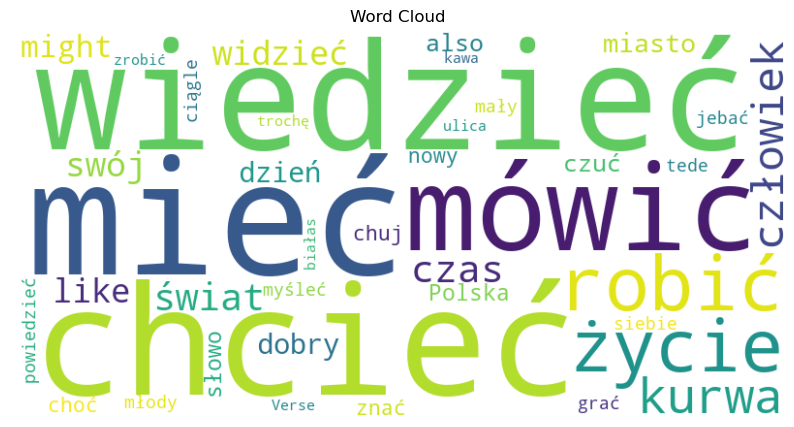

In [204]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

In [55]:
most_common_of_most_common

[('mieć', 68),
 ('chcieć', 58),
 ('wiedzieć', 58),
 ('życie', 30),
 ('mówić', 29),
 ('robić', 27),
 ('nie', 25),
 ('kurwa', 23),
 ('człowiek', 19),
 ('czas', 15),
 ('świat', 13),
 ('być', 10),
 ('swój', 10),
 ('like', 9),
 ('might', 8),
 ('dobry', 8),
 ('miasto', 7),
 ('dzień', 7),
 ('widzieć', 7),
 ('to', 5),
 ('Polska', 5),
 ('also', 4),
 ('znać', 4),
 ('słowo', 4),
 ('nowy', 4),
 ('siebie', 4),
 ('choć', 4),
 ('mały', 3),
 ('młody', 3),
 ('czuć', 3),
 ('grać', 3),
 ('każdy', 3),
 ('jebać', 3),
 ('ciągle', 3),
 ('tede', 3),
 ('białas', 2),
 ('ulica', 2),
 ('myśleć', 2),
 ('kawa', 2),
 ('który', 2)]

In [21]:
most_common_words = word_counts.most_common(30)

words = [word for word, count in most_common_words]
frequencies = [count for word, count in most_common_words]

In [41]:
import matplotlib.pyplot as plt

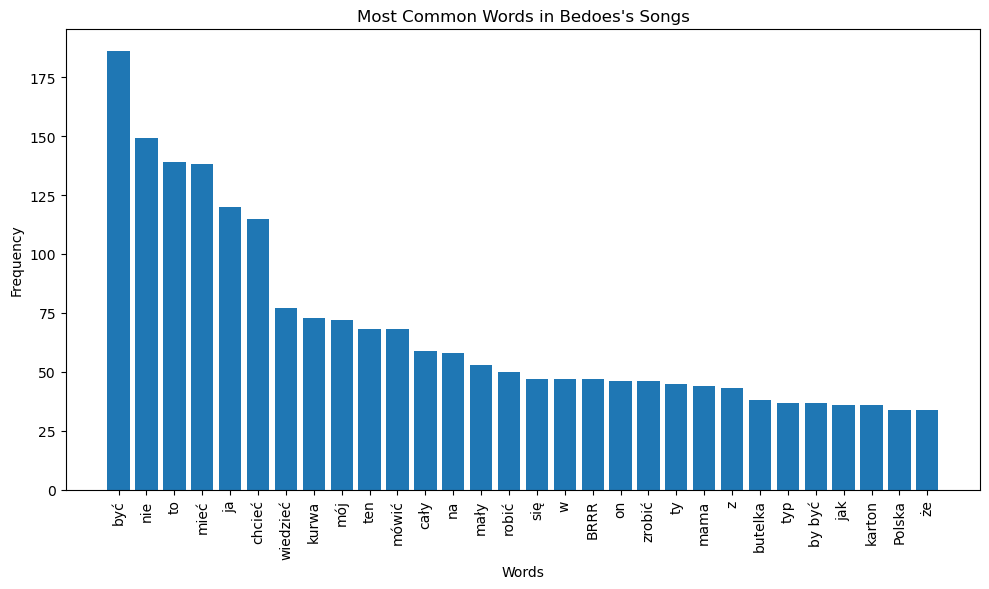

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Common Words in Bedoes\'s Songs')
plt.tight_layout()
plt.show()

In [56]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 1.9 MB/s eta 0:00:00a 0:00:01


In [58]:
from wordcloud import WordCloud 

In [31]:
most_common_words

[('być', 186),
 ('nie', 149),
 ('to', 139),
 ('mieć', 138),
 ('ja', 120),
 ('chcieć', 115),
 ('wiedzieć', 77),
 ('kurwa', 73),
 ('mój', 72),
 ('ten', 68),
 ('mówić', 68),
 ('cały', 59),
 ('na', 58),
 ('mały', 53),
 ('robić', 50),
 ('się', 47),
 ('w', 47),
 ('BRRR', 47),
 ('on', 46),
 ('zrobić', 46),
 ('ty', 45),
 ('mama', 44),
 ('z', 43),
 ('butelka', 38),
 ('typ', 37),
 ('by być', 37),
 ('jak', 36),
 ('karton', 36),
 ('Polska', 34),
 ('że', 34)]

In [32]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))

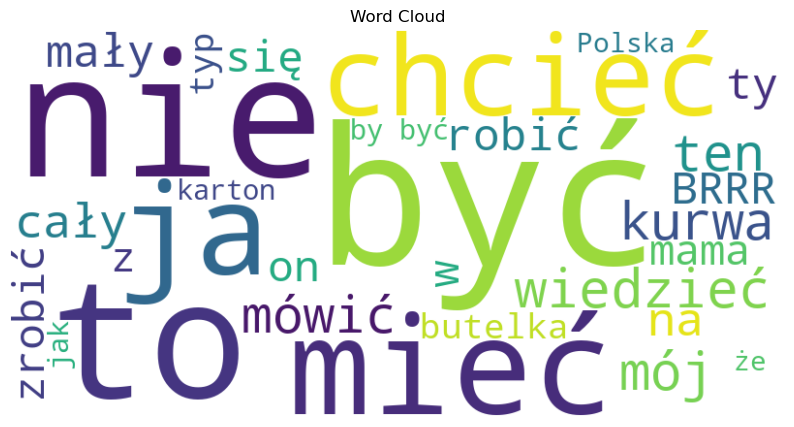

In [33]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

### 12. Syllables
#### 12.1. Mean syllables for each artist

In [63]:
import pyphen 
import numpy as np

In [64]:
# Load the Polish hyphenation dictionary
dic = pyphen.Pyphen(lang='pl_PL')

syllables = dic.inserted("interesująncy").count('-') + 1
print(syllables)

6


* Making a function that counts number of syllables for each word in a list, and then extracts the **mean**

In [138]:
import pyphen
def calculate_mean_syllables(list_1):
    syllable_counts = [dic.inserted(word).count('-') + 1 for word in list_1]
    return np.mean(syllable_counts)

In [205]:
per_artist_syllables = pd.DataFrame()  # Create an empty DataFrame with specified column names

for number in range(len(lyrics_per_artist['tokens'])):
    syllables = calculate_mean_syllables(lyrics_per_artist['tokens'][number])
    rapper_name = lyrics_per_artist['artist name'][number]
    data = pd.DataFrame({'Rapper': rapper_name, 'Mean': syllables}, index=[0])
    per_artist_syllables = pd.concat([per_artist_syllables, data])

In [206]:
df22 = per_artist_syllables.sort_values(by = ['Mean'], ascending = False)

In [60]:
df22[:10]

NameError: name 'df22' is not defined

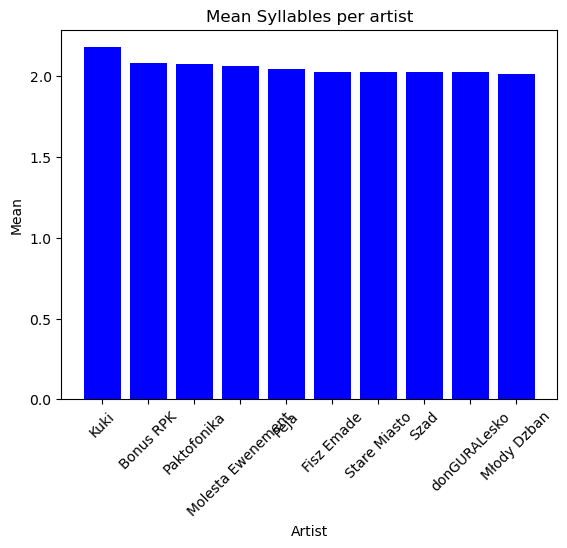

In [208]:
import matplotlib.pyplot as plt

# Example DataFrame with rapper names and means
import pandas as pd

df2 = df22[:10]

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(df2['Rapper'], df2['Mean'], color='blue')

# Add labels and title
ax.set_xlabel('Artist')
ax.set_ylabel('Mean')
ax.set_title('Mean Syllables per artist')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()


#### 12.2. Percentage of words that are multisyllabic, for each artist

In [155]:
import pyphen
def calculate_syllables(list_2):
    syllable_counts = [dic.inserted(word).count('-') + 1 for word in list_2]
    return syllable_counts

In [209]:
per_artist_syllables_percentage = pd.DataFrame()  # Create an empty DataFrame with specified column names

for number in range(len(lyrics_per_artist['tokens'])):
    syllables_2 = calculate_syllables(lyrics_per_artist['tokens'][number])
    rapper_name = lyrics_per_artist['artist name'][number]
    percentage = sum(1 for syllable in syllables_2 if syllable > 1) / len(syllables_2) * 100
    data1 = pd.DataFrame({'Rapper': [rapper_name], 'Syll': [syllables_2], 'percentage' : [percentage]})

    per_artist_syllables_percentage = pd.concat([per_artist_syllables_percentage, data1])

In [210]:
per_artist_syllables_percentage.sort_values(by = ['percentage'], ascending = False)


Rapper                                               Syll  \
0             Kuki  [1, 4, 2, 3, 3, 3, 2, 2, 3, 1, 1, 4, 1, 1, 1, ...   
0        Bonus RPK  [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 3, 2, 1, ...   
0           Pelson  [2, 1, 1, 1, 2, 3, 1, 3, 3, 2, 2, 3, 4, 1, 2, ...   
0      Stereofonia  [1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, ...   
0   Taco Hemingway  [2, 1, 2, 4, 2, 2, 2, 2, 1, 3, 2, 3, 2, 1, 1, ...   
..             ...                                                ...   
0           Bonson  [1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, ...   
0         Schafter  [1, 4, 1, 2, 3, 2, 2, 2, 2, 2, 2, 1, 1, 3, 2, ...   
0             Kabe  [2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 3, 2, 2, ...   
0      Young Multi  [1, 2, 5, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, ...   
0           asthma  [3, 1, 1, 2, 3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 2, ...   

    percentage  
0    75.803821  
0    74.628869  
0    73.868897  
0    73.378840  
0    72.512634  
..         ...  
0    62.626379  
0    61.559488  
0    61.133350  
0    60.235223  
0    46.413417  

[72 rows x 3 columns]

In [211]:
np.mean(per_artist_syllables_percentage['percentage'])

68.31304827278898

In [119]:
#!pip install spacy_syllables

+ Check this for stemming, perhaps: https://github.com/ipipan/spacy-pl
+ http://zil.ipipan.waw.pl/SpacyPL

 # ***Doing the LDA***

In [223]:
!pip install gensim

In [212]:
import gensim
from gensim.utils import simple_preprocess

/Users/anna/opt/anaconda3/envs/python-course/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4



In [6]:
#Create a dictionary from ‘dataset_stemmed’ containing the number of times a word appears in the training set.

In [213]:
dataset_stemmed

artist name                     title  year  \
0         Bedoes                    Gustaw  2017   
1         Bedoes  Kwiat Polskiej Młodzieży  2018   
2         Bedoes          #hot16Challenge2  2020   
3         Bedoes              NaNaNa REMIX  2015   
4         Bedoes                   Jumpman  2015   
...          ...                       ...   ...   
1977     Plan Be                Potrzebuję  2019   
1978     Plan Be                     Wiele  2017   
1979     Plan Be                  Pamiętam  2017   
1980     Plan Be             Złoty Chłopak  2019   
1981     Plan Be      Kryzysowa narzeczona  1983   

                                           clean lyrics  \
0     []\n(Jaok: Yyy, a jak oceniasz tę nową falę, k...   
1     []\nPora już wyłożyć prawdę na stół\nZ mamą dz...   
2     #hot16Challenge2 []\nCześć, z tej strony Borys...   
3     [: Bedoes]\nNigdy nie pozwolę być rodzinie gło...   
4     []\nEj, to jest Bedoes, to jest remix Jumpman,...   
...                                                 ...   
1977  [: PlanBe]\nPotrzebuję czegoś więcej wciąż\nŻy...   
1978  []\nWidzę wiele, wiele kłamstw\nWidzę wiele, w...   
1979  []\nNie zapomniałem kto mi mówił, że dla takic...   
1980  []\nYeah, yeah\nPlanek mówią na mnie\nYeah, ye...   
1981  [ x2]\nJak kryzysowa narzeczona\nPrzychodzisz ...   

                                                 tokens  
0     [Jaok, Yyy, oceniać, nowy, fala, YouTube, powi...  
1     [pora, wyłożyć, prawda, stół, mama, dzielić, s...  
2     [hot16Challenge2, cześć, strona, Borys, uważać...  
3     [Bedoes, pozwolić, rodzina, głodny, razem, squ...  
4     [Ej, Bedoes, remix, jumpman, Kubi, producent, ...  
...                                                 ...  
1977  [PlanBe, potrzebować, wciąż, życie, szybki, te...  
1978  [widzieć, kłamstwo, widzieć, ból, widzieć, str...  
1979  [zapomnieć, mówić, mieć, odwrócić, potykać, sy...  
1980  [Yeah, yeah, planek, mówić, Yeah, yeah, planek...  
1981  [x2, kryzysowy, narzeczona, Przychodzisz, odch...  

[1982 rows x 5 columns]

In [214]:
dictionary = gensim.corpora.Dictionary(dataset_stemmed['tokens'])

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 Artur
1 Bedoes
2 Bedoesa
3 Borek
4 Dawaj
5 Gada
6 Gonię
7 Gram
8 Gucci
9 Gustaw
10 Hollywoodzie


In [229]:
dictionary

ItemsView(<gensim.corpora.dictionary.Dictionary object at 0x7fb9c840f670>)

Filter out tokens that appear in:

+ less than 15 documents (absolute number) or
+ more than 0.5 documents (fraction of total corpus size, not absolute number).
+ after the above two steps, keep only the first 100000 most frequent tokens.

In [269]:
dictionary.filter_extremes(no_below=5, no_above=0.7, keep_n=100000)

Gensim doc2bow

For each document we create a dictionary reporting how many
words and how many times those words appear. Save this to ‘bow_corpus’, then check our selected document earlier.

In [270]:
bow_corpus = [dictionary.doc2bow(doc) for doc in dataset_stemmed['tokens']]

In [232]:
#Preview

bow_doc_4310 = bow_corpus[10]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))


Word 1 ("Bedoes") appears 1 time.
Word 2 ("Borek") appears 2 time.
Word 13 ("Polska") appears 1 time.
Word 14 ("SB") appears 3 time.
Word 34 ("brzydko") appears 1 time.
Word 46 ("czarny") appears 1 time.
Word 48 ("człowiek") appears 1 time.
Word 50 ("dać") appears 1 time.
Word 54 ("drugi") appears 4 time.
Word 55 ("dupa") appears 3 time.
Word 77 ("jakbym") appears 1 time.
Word 90 ("koncert") appears 1 time.
Word 108 ("musieć") appears 1 time.
Word 112 ("młody") appears 4 time.
Word 118 ("nowy") appears 1 time.
Word 131 ("outro") appears 1 time.
Word 136 ("pies") appears 1 time.
Word 142 ("po") appears 1 time.
Word 186 ("swój") appears 2 time.
Word 189 ("szanować") appears 1 time.
Word 191 ("szkoła") appears 1 time.
Word 198 ("tekst") appears 1 time.
Word 199 ("to") appears 1 time.
Word 202 ("trzeci") appears 1 time.
Word 203 ("trzymać") appears 1 time.
Word 221 ("zaczynać") appears 1 time.
Word 229 ("zostać") appears 1 time.
Word 230 ("zrobić") appears 1 time.
Word 253 ("auto") appears

**TF-IDF**

+ Create tf-idf model object using models. 
+ TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

In [233]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.08121527520696875),
 (1, 0.177462016930317),
 (2, 0.15811359552064203),
 (3, 0.04874213838204568),
 (4, 0.05363840546710884),
 (5, 0.04763901805676645),
 (6, 0.04897358806173894),
 (7, 0.06367360353531015),
 (8, 0.07718703954892368),
 (9, 0.0715095602654408),
 (10, 0.07272792722330529),
 (11, 0.06748132460739571),
 (12, 0.05777560966586775),
 (13, 0.026917581527532906),
 (14, 0.05777560966586775),
 (15, 0.07905679776032101),
 (16, 0.07905679776032101),
 (17, 0.07038877131092204),
 (18, 0.07905679776032101),
 (19, 0.20515505383438465),
 (20, 0.07905679776032101),
 (21, 0.05536929589422246),
 (22, 0.05777560966586775),
 (23, 0.05692672026071584),
 (24, 0.04785279910722019),
 (25, 0.07905679776032101),
 (26, 0.0347241539703258),
 (27, 0.054651067345221835),
 (28, 0.058220167220522964),
 (29, 0.05232066362138822),
 (30, 0.05019195501960344),
 (31, 0.05124924097723294),
 (32, 0.23717039328096307),
 (33, 0.06367360353531015),
 (34, 0.07905679776032101),
 (35, 0.13166416196391578),
 (3

**Running LDA using Bag of Words**

Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [273]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=3, id2word=dictionary, passes=10, workers=2)

In [274]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.008*"the" + 0.006*"robić" + 0.005*"kurwa" + 0.005*"yeah" + 0.005*"czas" + 0.004*"życie" + 0.004*"móc" + 0.004*"t" + 0.004*"it" + 0.004*"that"
Topic: 1 
Words: 0.008*"robić" + 0.007*"kurwa" + 0.005*"ej" + 0.005*"życie" + 0.005*"dać" + 0.005*"dobry" + 0.004*"człowiek" + 0.004*"widzieć" + 0.004*"raz" + 0.004*"zrobić"
Topic: 2 
Words: 0.007*"życie" + 0.006*"człowiek" + 0.006*"móc" + 0.006*"czas" + 0.005*"świat" + 0.005*"swój" + 0.005*"widzieć" + 0.005*"dzień" + 0.004*"żyć" + 0.004*"siebie"


In [264]:
bow_model = {
    "Topic 1" : ['móc', 'życie', 'człowiek', 'dobry', 'czas', 'kurwa',
                'żyć', 'robić', 'widzieć', 'dać'],
    "Topic 2" : ['życie', 'człowiek', 'widzieć', 'świat', 'miasto', 'robić',
                'czas', 'swój', 'dzień', 'raz'],
    "Topic 3" : ['robić', 'życie', 'kurwa', 'dać', 'czas', 'móc', 'nowy',
                 'człowiek', 'to', 'świat']
}

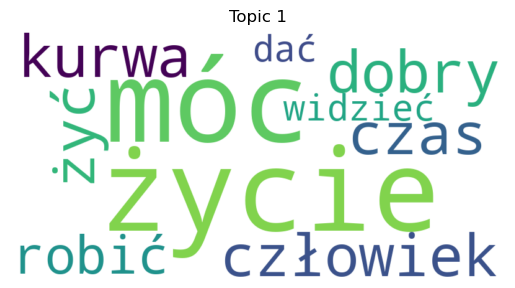

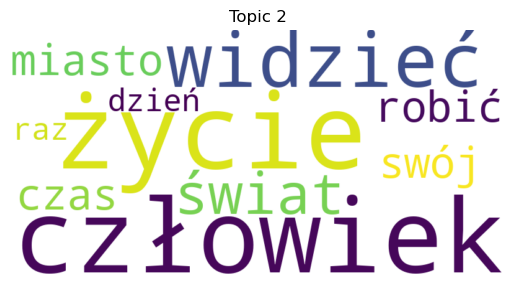

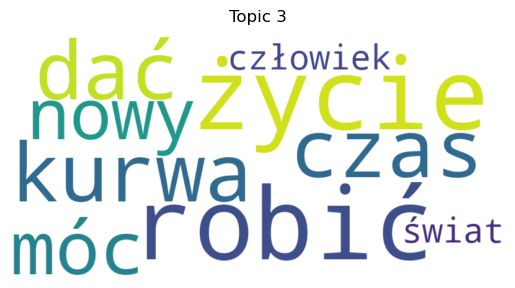

In [265]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create word clouds for each topic
for topic, words in bow_model.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(topic)
    plt.axis('off')

plt.show()


**Running LDA using TF-IDF**

In [290]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=3, id2word=dictionary, passes=2, workers=4)

In [291]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.001*"kurwa" + 0.001*"życie" + 0.001*"móc" + 0.001*"człowiek" + 0.001*"robić" + 0.001*"miasto" + 0.001*"raz" + 0.001*"rap" + 0.001*"powiedzieć" + 0.001*"dobry"
Topic: 1 Word: 0.001*"życie" + 0.001*"czas" + 0.001*"robić" + 0.001*"dom" + 0.001*"dzień" + 0.001*"świat" + 0.001*"nowy" + 0.001*"żyć" + 0.001*"serce" + 0.001*"swój"
Topic: 2 Word: 0.001*"życie" + 0.001*"dzień" + 0.001*"ej" + 0.001*"człowiek" + 0.001*"świat" + 0.001*"kurwa" + 0.001*"dobry" + 0.001*"dać" + 0.001*"widzieć" + 0.001*"móc"


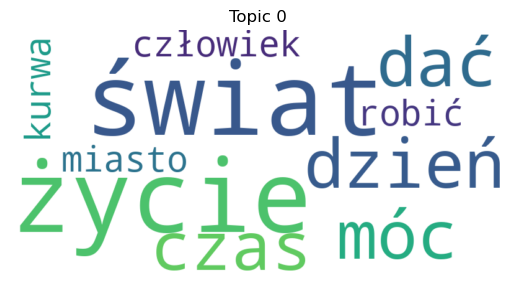

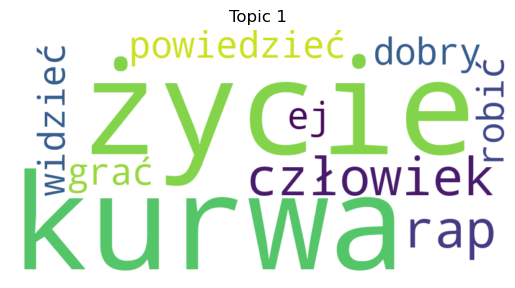

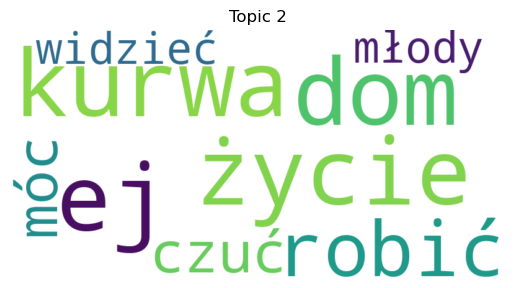

In [266]:
topic_model = {
    "Topic 0": ['świat', 'życie', 'dzień', 'móc', 'dać', 'czas', 'człowiek', 'miasto', 'robić', 'kurwa'],
    "Topic 1": ['kurwa', 'życie', 'człowiek', 'rap', 'powiedzieć', 'dobry', 'grać', 'widzieć', 'robić', 'ej'],
    "Topic 2": ['the', 'ej', 'życie', 'kurwa', 'dom', 'robić', 'czuć', 'móc', 'młody', 'widzieć']
}
# Create word clouds for each topic
for topic, words in topic_model.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(topic)
    plt.axis('off')

plt.show()

**Performance evaluation by classifying sample document using LDA Bag of Words model**

In [277]:
text = "Miasto wygląda dziś jak nigdy wcześniej Spokojna głowa zdąży zostawić te blizny jeszcze Póki co chcę więcej może pani zatrzymać tą resztę Wysoko lecę a miałem tylko wyjść przejść się Jak się patrzy mamy sposób jak zabraknie floty Zrobimy zrzutę każdy na oczach ma te pięć złotych UPS poszła szyba trzeba szybko stąd pryskać Ziomek pyta wkurwiony kto rozsypał ten kryształ Choć czasem wkurwia mnie bywa że mam go dość Kusi mnie światłami woła słyszę ten głos Znowu muszę wyjść kładę bagnet na broń Miasto Nocą Jak słońce zajdzie wtedy ma w sobie to coś Z kogo zadrwi komu dzisiaj zajebie w nos Ja i moja banda gotowi na ten lot Nocą Miasto Zaraz lont odpali bombę Wszystko wokół tu pierdolnie Wszystkie znaki mówią wolniej wolniej Zaraz lont odpali bombę Wszystko wokół tu pierdolnie Wszystkie znaki mówią wolniej wolniej Przez żołądek do serca trzymaj tu jeszcze pół Nie musisz podawać imienia nie teraz nie tu Gadamy na migi za głośny dzisiaj jest ten klub Ochroniarz wziął to do siebie że nie kumamy słów I chuj Morda nie szklanka gdzie moja szklanka morda Oczy kamer na nas na blokach chcą nagrać vloga Wyśpimy się po śmierci czyli jeszcze długa droga Przed chwilą się urodziłem uczę się stać na nogach Choć czasem wkurwia mnie bywa że mam go dość Kusi mnie światłami woła słyszę ten głos Znowu muszę wyjść kładę bagnet na broń Miasto Nocą Jak słońce zajdzie wtedy ma w sobie to coś Z kogo zadrwi komu dzisiaj zajebie w nos Ja i moja banda gotowi na ten lot Nocą Miasto Zaraz lont odpali bombę Wszystko wokół tu pierdolnie Wszystkie znaki mówią wolniej wolniej Zaraz lont odpali bombę Wszystko wokół tu pierdolnie Wszystkie znaki mówią wolniej wolniej"

words = text.split()
words

# Lemmatize each word in the list
lemmatized_words = []
for word in words:
    doc = nlp(word)
    lemmatized_words.append(doc[0].lemma_)

# Print the lemmatized words
print(type(lemmatized_words[0]))

for i in range(len(words)):
    words[i] = lemmatized_words[i]

# Print the updated list of words
print(words)

['miasto',
 'wyglądać',
 'dziś',
 'jak',
 'nigdy',
 'wcześnie',
 'spokojny',
 'głowa',
 'zdążyć',
 'zostawić',
 'ten',
 'blizna',
 'jeszcze',
 'póki',
 'co',
 'chcieć',
 'więcej',
 'móc',
 'pani',
 'zatrzymać',
 'ten',
 'reszta',
 'wysoko',
 'lecieć',
 'a',
 'mieć być',
 'tylko',
 'wyjść',
 'przejść',
 'się',
 'jak',
 'się',
 'patrzeć',
 'mieć',
 'sposób',
 'jak',
 'zabraknąć',
 'flota',
 'zrobić',
 'zrzuta',
 'każdy',
 'na',
 'oko',
 'mieć',
 'ten',
 'pięć',
 'złoty',
 'UPS',
 'pójść',
 'szyba',
 'trzeba',
 'szybko',
 'stąd',
 'pryskać',
 'ziomek',
 'pytać',
 'wkurwiyć',
 'kto',
 'rozsypać',
 'ten',
 'kryształ',
 'choć',
 'czas',
 'wkurwiać',
 'ja',
 'bywać',
 'że',
 'mieć',
 'on',
 'dość',
 'kusić',
 'ja',
 'światło',
 'wołać',
 'słyszeć',
 'ten',
 'głos',
 'znowu',
 'musieć',
 'wyjść',
 'kładeć',
 'bagnet',
 'na',
 'broń',
 'miasto',
 'Nocą',
 'jak',
 'słońce',
 'zajść',
 'wtedy',
 'mieć',
 'w',
 'siebie',
 'to',
 'coś',
 'z',
 'kto',
 'zadrwi',
 'kto',
 'dzisiaj',
 'zajeba',
 'w',


In [285]:
type(words)

list

In [287]:
dictionary_words = dictionary.doc2bow(words)
# bow_words = [dictionary_words.doc2bow(word) for word in words]

In [288]:
for index, score in sorted(lda_model[dictionary_words], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9220494627952576	 
Topic: 0.007*"życie" + 0.006*"człowiek" + 0.006*"móc" + 0.006*"czas" + 0.005*"świat" + 0.005*"swój" + 0.005*"widzieć" + 0.005*"dzień" + 0.004*"żyć" + 0.004*"siebie"

Score: 0.07639899849891663	 
Topic: 0.008*"robić" + 0.007*"kurwa" + 0.005*"ej" + 0.005*"życie" + 0.005*"dać" + 0.005*"dobry" + 0.004*"człowiek" + 0.004*"widzieć" + 0.004*"raz" + 0.004*"zrobić"


**Performance evaluation by classifying sample document using LDA TF-IDF model.**

In [292]:
for index, score in sorted(lda_model_tfidf[dictionary_words], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.9374219179153442	 
Topic: 0.001*"życie" + 0.001*"dzień" + 0.001*"ej" + 0.001*"człowiek" + 0.001*"świat" + 0.001*"kurwa" + 0.001*"dobry" + 0.001*"dać" + 0.001*"widzieć" + 0.001*"móc"

Score: 0.06086229532957077	 
Topic: 0.001*"życie" + 0.001*"czas" + 0.001*"robić" + 0.001*"dom" + 0.001*"dzień" + 0.001*"świat" + 0.001*"nowy" + 0.001*"żyć" + 0.001*"serce" + 0.001*"swój"
